In [1]:
#Real life data

import logging
import threading
import itertools
import math
import datetime
import pandas as pd  
import numpy as np  
import scipy as sp
import json
import ibm_db

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore, DBModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor,)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster, KDEAnomalyScore, VIAnomalyScore)
#from poc.functions import State_Timer
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)




In [2]:
# install umap-learn, gensim and python-Levenshtein
import umap 
import gensim
from gensim.models import Word2Vec, FastText


In [3]:
df_raw_const = pd.read_fwf('./data/dataids.txt', header=None)
df_const = df_raw_const[0].str.split(',', expand=True)

In [16]:
df_raw_dyn = pd.read_fwf('./data/recentdata.txt', header=None)
df_dyn = df_raw_dyn[0].str.split(',', expand=True)

In [6]:
df_dyn[45345:45346]

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
45345,167388,5,5,1623346986349,[Ljava.lang.Object;@650e7502,53351023,0,[Ljava.lang.Object;@27df5748,104580383,0,...,None,None,None,None,None,None,None,None,None,None


In [11]:
df_dyn.index

RangeIndex(start=0, stop=111955, step=1)

In [17]:
df_merged = df_dyn.merge(df_const, how='inner', on=[0])

In [26]:
df_merged[['3_x','4_x','5_y']]

,3_x,4_x,5_y
0,1623346986062,0,METHOD_ENTRY
1,1623346986062,0,LABEL
2,1623346986062,0,LINE_NUMBER
3,1623346986062,0,CALL
4,1623346986062,0,CALL_RETURN
...,...,...,...
111950,1623346986749,false,CALL_RETURN
111951,1623346986749,411342,LABEL
111952,1623346986749,0,LINE_NUMBER
111953,1623346986749,java.util.ArrayList@6211133a,LOCAL_LOAD


In [27]:
np_dataset = df_merged[['3_x','4_x','5_y']].values

In [28]:
# minimal cleansing - drop NaNs
dataset = []
for row in np_dataset:
    dataset.append([x for x in row if pd.isnull(x) == False])

In [48]:
# dataset

In [31]:

w2v = Word2Vec(dataset, vector_size=300, window=5, min_count=1) #, workers=4)

2021-06-11T18:13:24.908 INFO gensim.models.word2vec.scan_vocab collecting all words and their counts
2021-06-11T18:13:24.912 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-11T18:13:24.934 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #10000, processed 30000 words, keeping 1400 word types
2021-06-11T18:13:24.948 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #20000, processed 60000 words, keeping 2570 word types
2021-06-11T18:13:24.956 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #30000, processed 90000 words, keeping 3801 word types
2021-06-11T18:13:24.964 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #40000, processed 120000 words, keeping 4708 word types
2021-06-11T18:13:24.972 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #50000, processed 150000 words, keeping 5697 word types
2021-06-11T18:13:24.980 INFO gensim.models.word2vec._scan_voca

In [32]:
w2v.wv['METHOD_NORMAL_EXIT']

array([ 1.73638061e-01,  3.06997210e-01,  4.37911242e-01, -2.68451184e-01,
        1.94756195e-01,  3.54577661e-01,  3.86496514e-01,  4.76750955e-02,
        7.72646010e-01,  1.91685766e-01, -7.64462292e-01, -5.71463764e-01,
        3.42088670e-01, -4.46078330e-02, -1.02250680e-01,  8.68509561e-02,
       -1.08085960e-01,  5.79202652e-01,  4.00576800e-01,  3.01814169e-01,
        1.32897809e-01, -3.46030384e-01, -1.57796144e-01,  1.81340322e-01,
       -2.20318109e-01,  4.37474668e-01, -3.88083905e-01,  2.93467611e-01,
        2.01765031e-01, -3.50402355e-01,  5.91934800e-01, -4.23004985e-01,
        1.69056192e-01,  1.51882544e-01,  1.89540148e-01, -1.73848197e-01,
        1.25225931e-01,  4.52896319e-02, -4.42381918e-01,  2.13816628e-01,
        1.44395947e-01,  1.57314792e-01,  4.86768007e-01,  2.10755337e-02,
       -1.48921907e-01,  4.29117888e-01,  3.84583622e-01,  3.15115750e-01,
       -4.60337579e-01, -1.55685423e-02, -1.13828093e-01, -6.31041452e-02,
        3.89936268e-01, -

In [33]:
# for the sake of it
vocab = list(w2v.wv.key_to_index)
X = w2v.wv[vocab]

In [49]:
vocab[799]

'java.lang.String@3b588591:"jsp"'

In [42]:
X[0:10000].shape

(10000, 300)

In [43]:
import umap
vec_umap = umap.UMAP()
X_umap = vec_umap.fit_transform(X[0:1000])


In [54]:
vocab[2]

'LINE_NUMBER'

'\nnr = 1\nadjust_text(texts, arrowprops=dict(arrowstyle=\'->\', color=\'red\'))\nax.annotate(vocab[nr], xy=(X_umap.T[0][nr], X_umap.T[1][nr]), xytext=(X_umap.T[0][nr]+4, X_umap.T[1][nr] + 4),\n            annotation_clip=False,\n            arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"));\nnr = 2\nax.annotate(vocab[nr], xy=(X_umap.T[0][nr], X_umap.T[1][nr]), xytext=(X_umap.T[0][nr]-7, X_umap.T[1][nr]+1),\n            arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"));\nnr = 3\nax.annotate(vocab[nr], xy=(X_umap.T[0][nr], X_umap.T[1][nr]), xytext=(X_umap.T[0][nr]-7, X_umap.T[1][nr]-2),\n            arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"));\n'

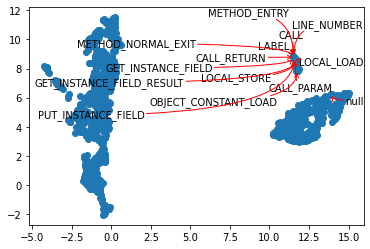

In [67]:
from adjustText import adjust_text
# hmm, a Rorschach test
# at least it turns out that CALL_RETURN and LABEL are more similar than 'Ljava/lang/Object;'
fig, ax = plt.subplots()
ax.scatter(X_umap.T[0],X_umap.T[1])

texts = [plt.text(X_umap.T[0][nr], X_umap.T[1][nr], vocab[nr], ha='center', va='center') for nr in range(1,15)]
adjust_text(texts, arrowprops=dict(arrowstyle='->', connectionstyle="angle3,angleA=0,angleB=-90", color='red'))
'''
nr = 1
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
ax.annotate(vocab[nr], xy=(X_umap.T[0][nr], X_umap.T[1][nr]), xytext=(X_umap.T[0][nr]+4, X_umap.T[1][nr] + 4),
            annotation_clip=False,
            arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"));
nr = 2
ax.annotate(vocab[nr], xy=(X_umap.T[0][nr], X_umap.T[1][nr]), xytext=(X_umap.T[0][nr]-7, X_umap.T[1][nr]+1),
            arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"));
nr = 3
ax.annotate(vocab[nr], xy=(X_umap.T[0][nr], X_umap.T[1][nr]), xytext=(X_umap.T[0][nr]-7, X_umap.T[1][nr]-2),
            arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"));
'''

In [69]:
# it appears I still have to do some cleansing, but it's getting better
vocab[1], vocab[3], vocab[4], vocab[14]

('LABEL', 'CALL', 'CALL_RETURN', 'PUT_INSTANCE_FIELD')

### Just ignore everything below
---------------- snip ---------------- snip ---------------- snip ----------------

In [21]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

np_dataset = df.fillna('').values

dct = Dictionary(np_dataset)



/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-06-10T11:37:01.665 INFO gensim.corpora.dictionary.add_documents adding document #0 to Dictionary(0 unique tokens: [])
2021-06-10T11:37:01.777 INFO gensim.corpora.dictionary.add_documents adding document #10000 to Dictionary(13948 unique tokens: ['', '-1', '0', 'RESERVED', 'V']...)
2021-06-10T11:37:01.895 INFO gensim.corpora.dictionary.add_documents adding document #20000 to Dictionary(26873 unique tokens: ['', '-1', '0', 'RESERVED', 'V']...)
2021-06-10T11:37:02.012 INFO gensim.corpora.dictionary.add_documents adding document #30000 to Dictionary(40009 unique tokens: ['', '-1', '0', 'RESERVED', 'V']...)
2021-06-10T11:37:02.131 INFO gensim.corpora.dictionary.add_documents adding document #40000 to Dictionary(52744 unique tokens: ['', '-1', '0', 'RESERVED', 'V']...)
2021-06-10T11:37:02.246 INFO gensim.corpora.dictionary.add_documents adding document #50000 to Dictionary(65611 unique tokens: ['', '-1', '0', 'RESERVED', 'V']...)
2021-06-10T11:37:02.372 INFO gensim.corpora.dictionary.ad

In [47]:
model.wv

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'TfidfModel' object has no attribute 'wv'

In [22]:
corpus = [dct.doc2bow(line) for line in np_dataset]

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
model = TfidfModel(corpus)

2021-06-10T11:37:32.567 INFO gensim.models.tfidfmodel.initialize collecting document frequencies
2021-06-10T11:37:32.570 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #0
2021-06-10T11:37:32.606 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #10000
2021-06-10T11:37:32.627 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #20000
2021-06-10T11:37:32.645 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #30000
2021-06-10T11:37:32.662 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #40000
2021-06-10T11:37:32.675 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #50000
2021-06-10T11:37:32.690 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #60000
2021-06-10T11:37:32.703 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #70000
2021-06-10T11:37:32.716 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing docum

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-06-10T11:37:32.784 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #130000
2021-06-10T11:37:32.802 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #140000
2021-06-10T11:37:32.816 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #150000
2021-06-10T11:37:32.828 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #160000
2021-06-10T11:37:32.845 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #170000
2021-06-10T11:37:32.859 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #180000
2021-06-10T11:37:32.872 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #190000
2021-06-10T11:37:32.885 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #200000
2021-06-10T11:37:32.899 INFO gensim.models.tfidfmodel.initialize PROGRESS: processing document #210000
2021-06-10T11:37:32.912 INFO gensim.models.tfidfmodel.initialize PROGRESS

In [28]:
np_dataset

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([['0', '0', '0', ..., '', '', ''],
       ['1', '0', '0', ..., '', '', ''],
       ['2', '0', '0', ..., '', '', ''],
       ...,
       ['393010', '663', '8562', ..., '', '', ''],
       ['393011', '663', '8562', ..., '', '', ''],
       ['393012', '663', '8562', ..., '', '', '']], dtype=object)

In [36]:
from gensim.models import Word2Vec, FastText
w2v = Word2Vec(np_dataset, vector_size=100, window=5, min_count=1) #, workers=4)

2021-06-10T11:45:28.605 INFO gensim.models.word2vec.scan_vocab collecting all words and their counts
2021-06-10T11:45:28.606 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-10T11:45:28.642 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #10000, processed 130000 words, keeping 13948 word types
2021-06-10T11:45:28.665 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #20000, processed 260000 words, keeping 26873 word types
2021-06-10T11:45:28.692 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #30000, processed 390000 words, keeping 40009 word types
2021-06-10T11:45:28.719 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #40000, processed 520000 words, keeping 52744 word types
2021-06-10T11:45:28.743 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #50000, processed 650000 words, keeping 65611 word types
2021-06-10T11:45:28.769 INFO gensim.models.word2vec._s

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-06-10T11:45:28.822 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #80000, processed 1040000 words, keeping 103367 word types
2021-06-10T11:45:28.850 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #90000, processed 1170000 words, keeping 115987 word types
2021-06-10T11:45:28.877 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #100000, processed 1300000 words, keeping 129052 word types
2021-06-10T11:45:28.904 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #110000, processed 1430000 words, keeping 141840 word types
2021-06-10T11:45:28.929 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #120000, processed 1560000 words, keeping 154567 word types
2021-06-10T11:45:28.955 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #130000, processed 1690000 words, keeping 166995 word types
2021-06-10T11:45:28.983 INFO gensim.models.word2vec._scan_vocab PROGRESS: at sentence #140000, processed 1820000 words, keepin

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 954, in _bootstrap_inner
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 954, in _bootstrap_inner
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 954, in _bootstrap_inner
        self.run()
self.run()
  File "/usr/lib/python3.9/threading.py", line 892, in run
  File "/usr/lib/python3.9/threading.py", line 892, in run
        self._target(*self._args, **self._kwargs)
  File "/home/markus/.local/lib/python3.9/site-packages/gensim/models/word2vec.py", line 1155, in _worker_loop
    self.run()
  File "/usr/lib/python3.9/threading.py", line 892, in run
self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/markus/.local/lib/python3.9/site-packages/gensim/models/word2vec.py", line 1155, in _worker_loop
  Fil

KeyboardInterrupt: 

In [25]:
vector

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.003180367836896374),
 (1, 0.43117049283736947),
 (2, 0.47904036863255917),
 (3, 0.21558524641868473),
 (4, 0.10668838349680328),
 (5, 0.7257704919191865)]

In [15]:
from gensim.models.fasttext import FastText

model = FastText(vector_size=100)

model.build_vocab(corpus_file=df)

2021-06-10T11:14:30.127 INFO gensim.utils.add_lifecycle_event FastText lifecycle event {'params': 'FastText(vocab=0, vector_size=100, alpha=0.025)', 'datetime': '2021-06-10T11:14:30.127270', 'gensim': '4.0.1', 'python': '3.9.5 (default, May 11 2021, 08:20:37) \n[GCC 10.3.0]', 'platform': 'Linux-5.11.0-18-generic-x86_64-with-glibc2.33', 'event': 'created'}


/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: stat: path should be string, bytes, os.PathLike or integer, not DataFrame

In [65]:
# deviceid 56851666-8346-32f0-bd8b-d77d82f63028
# tag path ca3e/hvac/scrubbers/shx7/at702/eu
df_raw = pd.read_csv('IOT_LAMUCS1_ANALOG_TYPE_202106021859.csv', parse_dates=['RCV_TIMESTAMP_UTC'],
                     infer_datetime_format=True)
df_raw['RCV_TIMESTAMP_UTC'] = pd.to_datetime(df_raw['RCV_TIMESTAMP_UTC'], 
                                            format='%Y-%m-%d-%H.%M.%S.%f')
df_raw = df_raw.sort_values('RCV_TIMESTAMP_UTC')
df = df_raw.set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])

In [69]:
df_raw['RCV_TIMESTAMP_UTC']

0      2021-05-01 00:21:10.031
1      2021-05-01 00:21:10.031
3865   2021-05-01 00:21:10.031
3866   2021-05-01 00:21:10.031
3867   2021-05-01 00:45:37.052
                 ...          
413    2021-05-29 12:21:40.712
414    2021-05-29 12:23:30.750
415    2021-05-29 12:23:30.750
417    2021-05-30 23:59:20.880
416    2021-05-30 23:59:20.880
Name: RCV_TIMESTAMP_UTC, Length: 5590, dtype: datetime64[ns]

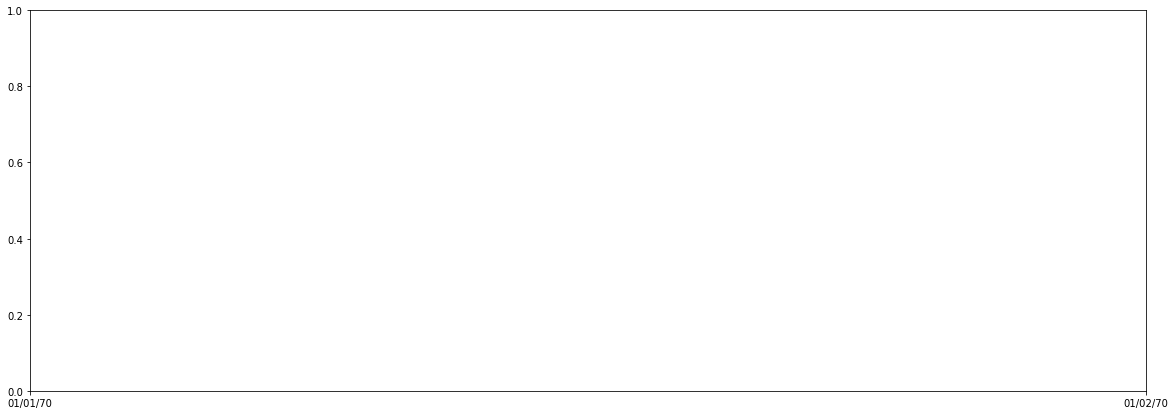

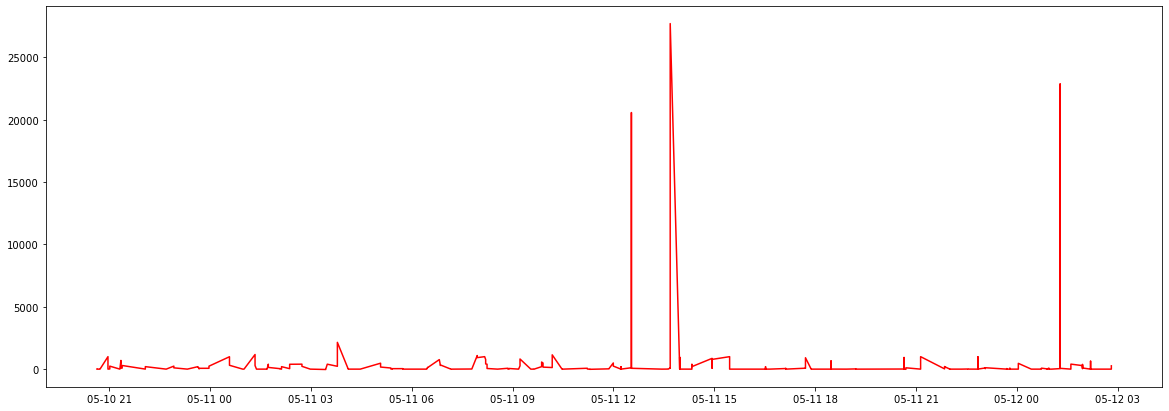

In [77]:
ax = plt.gca()
#ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator([1, 7]))
#ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%b'))
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
#ax.tick_params(pad=20)

plt.figure(figsize=(20,7))
plt.plot(df_raw[2200:2500]['RCV_TIMESTAMP_UTC'], df_raw[2200:2500]['FLOATVALUE'], color='red') #, figsize=(20,5))
